# Проект - Телеком

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

* Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание полей данных

* BeginDate - дата начала пользования услугами
* EndDate - дата окончания пользования услугами
* Type - тип оплаты: ежемесячный/годовой
* PaperlessBilling - электронный платежный документ
* PaymentMethod - способ оплаты
* MonthlyCharges - ежемесячные траты на услуги
* TotalCharges - всего потрачено денег на услуги
* Dependents - наличие иждивенцев
* Senior Citizen - наличие пенсионного статуса по возрасту
* Partner - наличие супруга(и)
* MultipleLines - наличие возможности ведения параллельных линий во время звонка

## Цель и задачи

* **Цель**:
    Построить модель, которая может предсказать уйдет ли клиент или нет, где метрика ROC-AUC > 0.85
* **Задачи**:

    Загрузить данные
    
    Провести анализ и предобработку данных
    
    Подобрать модель
    
    Проверить модель
    
    Сформулировать выводы

# Анализ данных

Загружаем библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
RANDOM_STATE = 80523

## contract_new

Загружаем первый датасет

In [3]:
    contract = pd.read_csv('contract_new.csv')

In [4]:
display(contract.head(5))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [5]:
contract.shape

(7043, 8)

In [6]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пара выводов: в датасете нет пропусков ни в одном из столбцов и в TotalCharges видимо есть строки, которые и дают тип object, надо бы его перевести в float

In [7]:
contract.loc[contract['TotalCharges']==' ', 'TotalCharges'] = 0.0

contract['TotalCharges'] = contract['TotalCharges'].astype('float')

Эти пробелы которые были в столбце TotalCharges я заменила на 0, возможно что это люди у которых еще не было первого платежа.

In [8]:
contract.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2115.312885
std,30.090047,2112.742814
min,18.250000,0.000000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


В среднем ежемесячная плата - 65, в среднем общий платеж - 2115. Самый дешевый ежмесячный платеж - 18, а 25% пользователей каждый месяц платят от 18 до 35. 

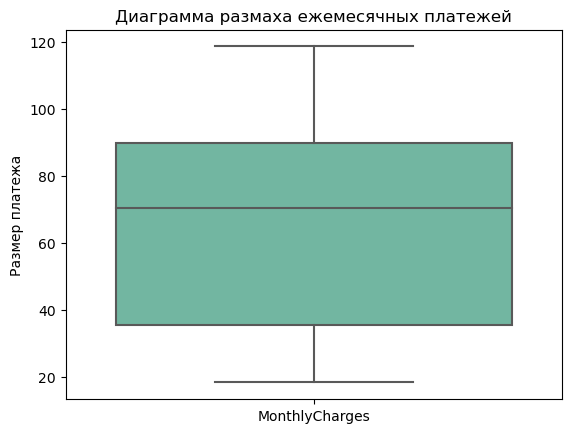

In [9]:
x = sns.boxplot(data=contract[['MonthlyCharges']], palette="Set2")
x.set_title('Диаграмма размаха ежемесячных платежей')
x.set_ylabel('Размер платежа');

Интересно, что в MonthlyCharges не видно выбросов, сам ящик расположен почти идеально по середине, а медиана смещена немного наверх. То есть половина пользователей платит меньше 70, половина - больше.

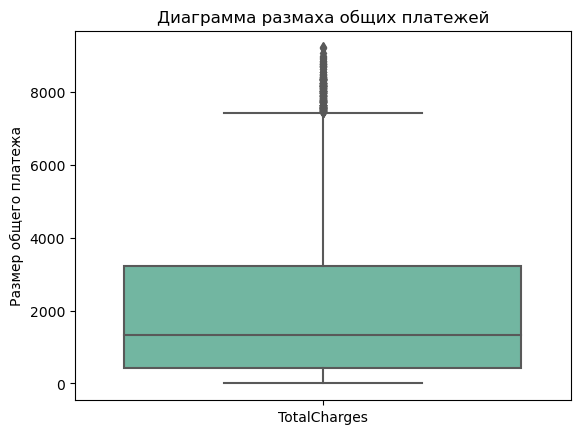

In [10]:
x = sns.boxplot(data=contract[['TotalCharges']], palette='Set2')
x.set_title('Диаграмма размаха общих платежей')
x.set_ylabel('Размер общего платежа');

В TotalCharges ящик сильно смещен вниз, половина клиентов заплатили меньше ~1300, есть выбросы в видке клиентов, кто заплатил больше 8000. Разница в размахе между нижней половиной и верхней - существенная

In [11]:
contract['EndDate'].value_counts().head(2)

No            5942
2020-01-01      39
Name: EndDate, dtype: int64

* Так как у нас всего 7043 записи, то логично предположить что людей у котрых контракт расторгнут (они ушли) = 1 101
* То есть у нас будет дисбаланс классов, но наша метрика не будет к этому чувствительна

In [12]:
contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

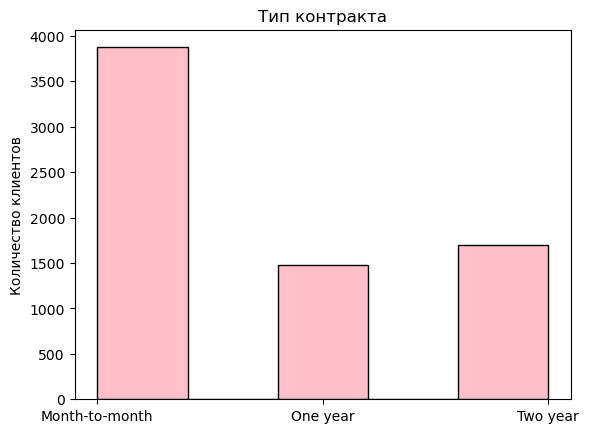

In [13]:
plt.hist (contract['Type'], color = 'pink', bins=5, ec="black", lw= 1);
plt.title('Тип контракта')
plt.ylabel('Количество клиентов');

Большинство клиентов предпочитают ежемесячную оплату, при этом тех, у кого контракт заключен на два года - больше, чем тех кто заключал договор на один год, хоть и незначительно. Но в сумме тех, кто заключает контракт на год и на два года - 3 168, что приближается к числу тех, кто платит ежемесячно.
* То есть если делить на группы: помесячная оплата и нет, то эти группы будут равнозначны

In [14]:
contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

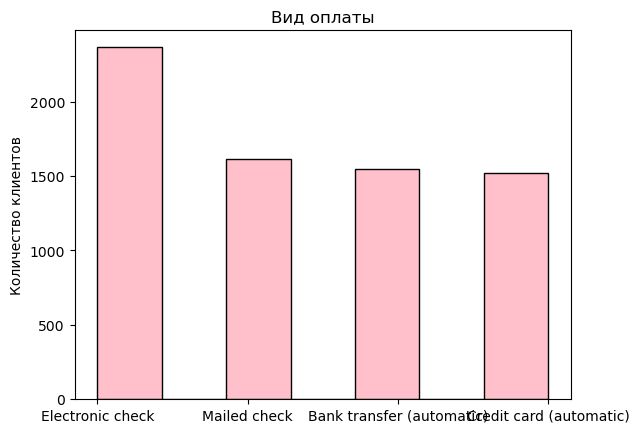

In [15]:
plt.hist (contract['PaymentMethod'], color = "pink", bins=7, ec="black", lw= 1);
plt.title('Вид оплаты')
plt.ylabel('Количество клиентов');

Большинство клиентов предпочитает форму оплаты - Electronic check, остальные формы оплаты занимают примерно равную долю в полторы тысячи клиентов. Автоматические методы оплаты предпочитают в сумме 3 066 клиента. Не автоматический - 3 977.

### Заметки по contract_new

* Из 7043 клиентов 5942 являются действующими клиентами - это 84,37% от всех пользователей
* 25% пользователей каждый месяц платят от 18 до 35
* В основном люди предпочитают ежемесячную плату
* Большинство клиентов предпочитает форму оплаты - Electronic check

## internet_new

In [16]:
internet = pd.read_csv('internet_new.csv')

In [17]:
display(internet.head(5))

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [18]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [19]:
internet.shape

(5517, 8)

В этом датасете меньше записей и кроме айди клиента нет пересекающихся столбцов с предыдущей таблицей,и все они категориальные

In [20]:
internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

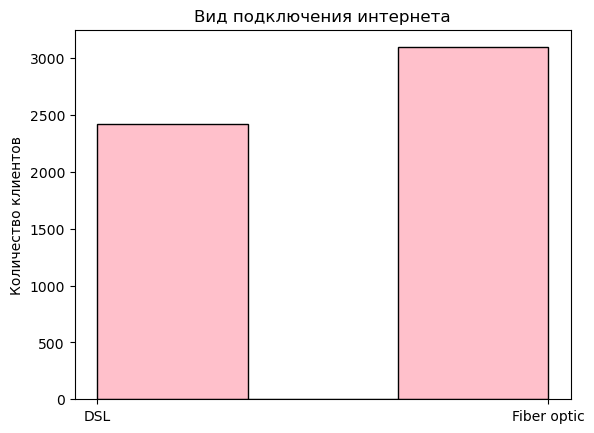

In [21]:
plt.hist (internet['InternetService'], color = "pink", bins=3, ec="black", lw= 1);
plt.title('Вид подключения интернета')
plt.ylabel('Количество клиентов');

DSL немного меньше чем Fiber optic

In [22]:
internet['OnlineSecurity'].value_counts()

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

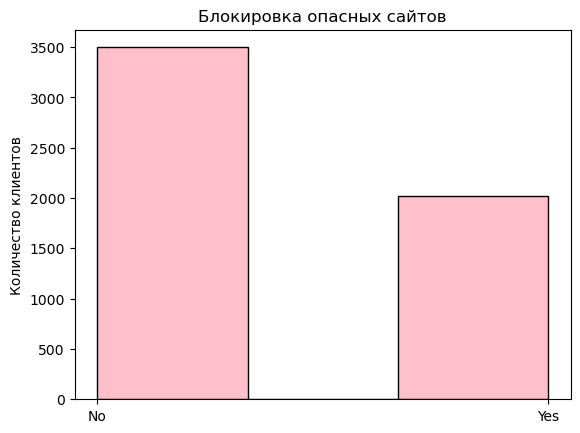

In [23]:
plt.hist (internet['OnlineSecurity'], color = "pink", bins=3, ec="black", lw= 1);
plt.title('Блокировка опасных сайтов')
plt.ylabel('Количество клиентов');

Большинство клиентов не подключают Online Security

In [24]:
internet['OnlineBackup'].value_counts()

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

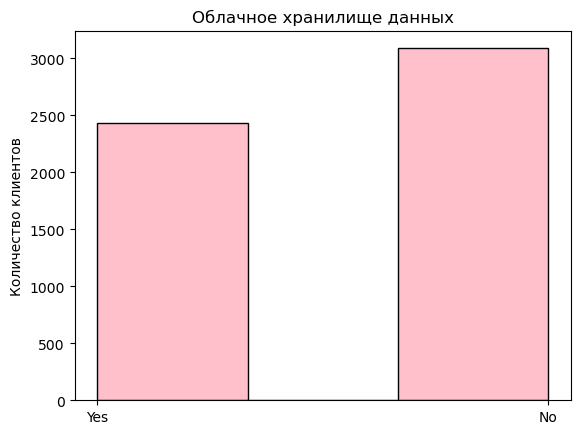

In [25]:
plt.hist (internet['OnlineBackup'], color = "pink", bins=3, ec="black", lw= 1);
plt.title('Облачное хранилище данных')
plt.ylabel('Количество клиентов');

Также большинство не подключают Online Backup

In [26]:
internet['DeviceProtection'].value_counts()

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

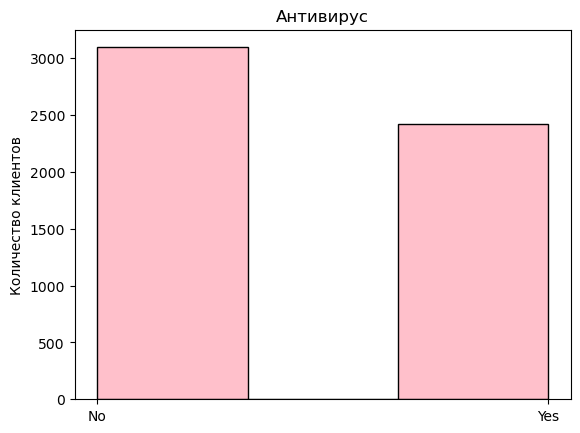

In [27]:
plt.hist (internet['DeviceProtection'], color = "pink", bins=3, ec="black", lw= 1);
plt.title('Антивирус')
plt.ylabel('Количество клиентов');

Большинство не пользуется Device Protection

In [28]:
internet['TechSupport'].value_counts()

No     3473
Yes    2044
Name: TechSupport, dtype: int64

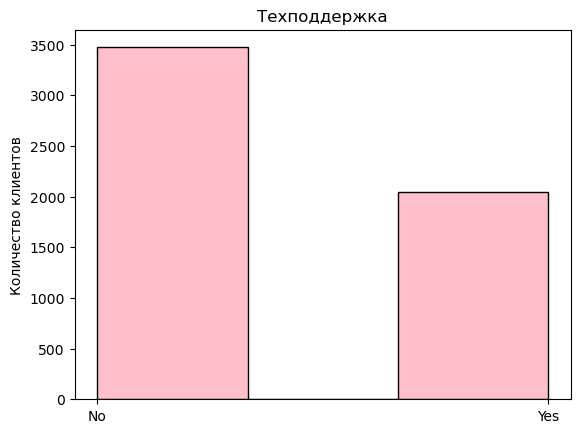

In [29]:
plt.hist (internet['TechSupport'], color = "pink", bins=3, ec="black", lw= 1);
plt.title('Техподдержка')
plt.ylabel('Количество клиентов');

Большинсво не использует услуги тех поддержки

In [30]:
internet['StreamingTV'].value_counts()

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

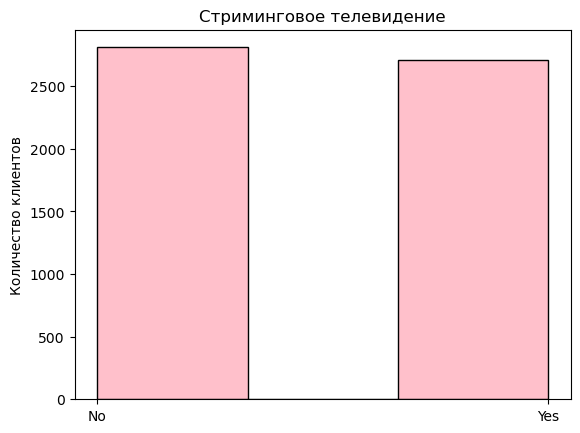

In [31]:
plt.hist (internet['StreamingTV'], color = "pink", bins=3, ec="black", lw= 1);
plt.title('Стриминговое телевидение')
plt.ylabel('Количество клиентов');

Равнозначное количество людей у которых подключено Streaming TV

In [32]:
internet['StreamingMovies'].value_counts()

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

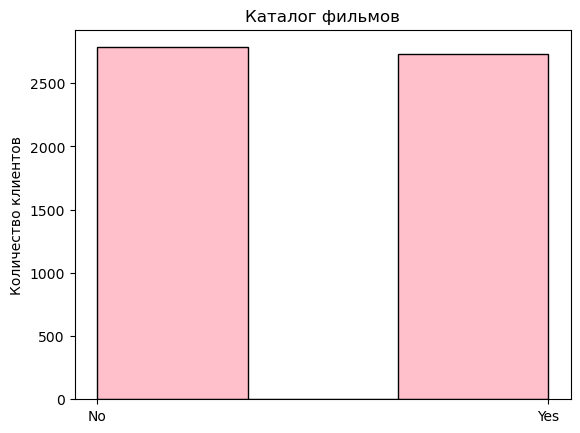

In [33]:
plt.hist (internet['StreamingMovies'], color = "pink", bins=3, ec="black", lw= 1);
plt.title('Каталог фильмов')
plt.ylabel('Количество клиентов');

Такие же показатели и для Streaming Movies, подключенных и неподключенных примерно равное количество

### Заметки по internet_new

Глобальная закономерность - большинство клиентов скорее *не* пользуются доп услугами интеренета, чем пользуются, за двумя исключениями - Streaming TV и Streaming Movies, то есть это наиболее инетересные для клиентов опции.

## personal_new

In [34]:
personal = pd.read_csv('personal_new.csv')

In [35]:
display(personal.head(5))

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [36]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Здесь у нас личная информация о пользователях

In [37]:
personal.shape

(7043, 5)

Записей столько же сколько и в основном датасете

In [38]:
personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

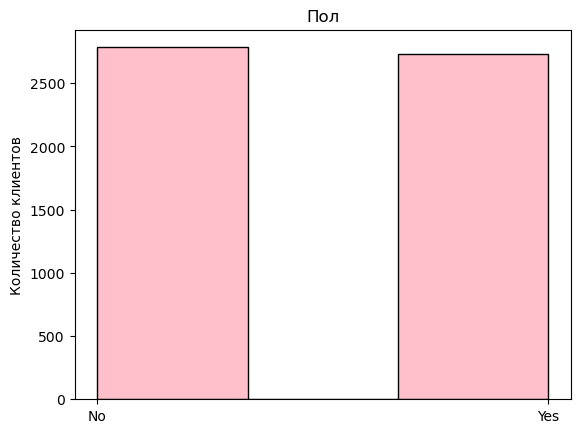

In [39]:
plt.hist (internet['StreamingMovies'], color = "pink", bins=3, ec="black", lw= 1);
plt.title('Пол')
plt.ylabel('Количество клиентов');

Распеределение полов - равное, женщин и мужчин примерно одинаковое количество, но буквально немного перевес в сторону мужчин. На самом деле это интересно, так как мне казалось что обычно в семье подключают интернет отцы/старшие братья. Если мы говорим про простой телефон, то распределение логично было бы ожидать равномерное. В совокупности мужчин по идее должно было быть больше, а их больше не сильно.

In [40]:
personal['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [41]:
personal['SeniorCitizen'] = np.where(personal['SeniorCitizen'] == 0, 'No', 'Yes')

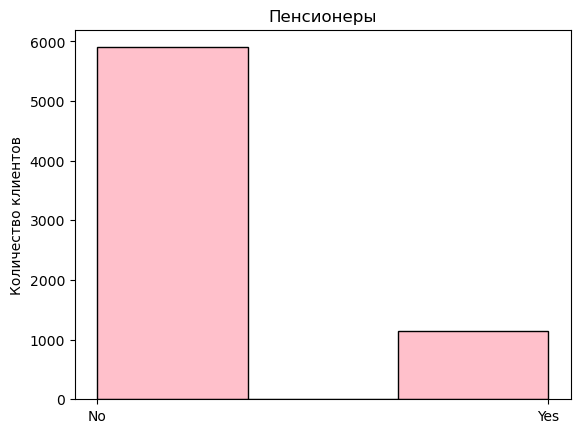

In [42]:
plt.hist (personal['SeniorCitizen'], color = "pink", bins=3, ec="black", lw= 1);
plt.title('Пенсионеры')
plt.ylabel('Количество клиентов');

Пенсионеры среди клиентов составляют только 16%.

In [43]:
personal['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

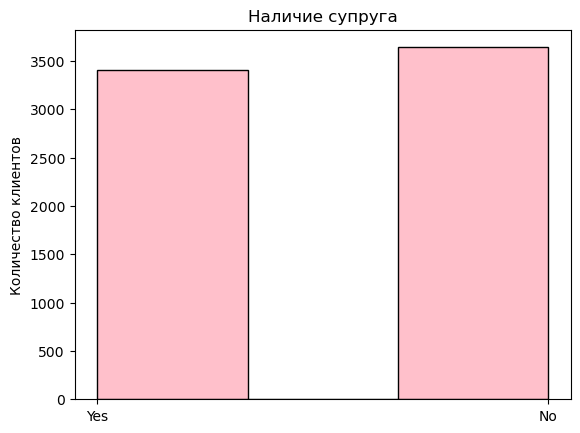

In [44]:
plt.hist (personal['Partner'], color = "pink", bins=3, ec="black", lw= 1);
plt.title('Наличие супруга')
plt.ylabel('Количество клиентов');

С небольшим перевесом выходит группа людей, у которых нет партнера

In [45]:
personal['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

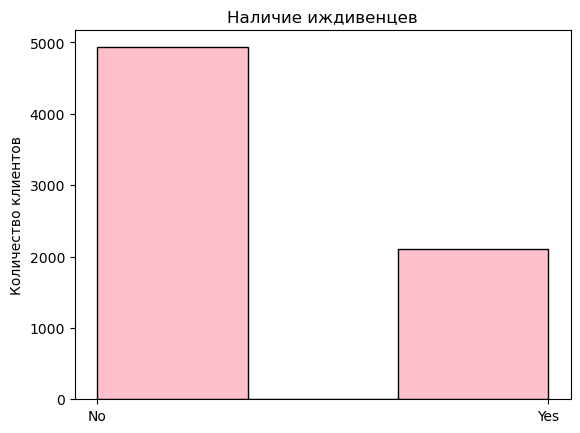

In [46]:
plt.hist (personal['Dependents'], color = "pink", bins=3, ec="black", lw= 1);
plt.title('Наличие иждивенцев')
plt.ylabel('Количество клиентов');

У большинства нет иждивенцев. Иждивенцы есть только у 29,9% клиентов

### Заметки по personal_new

* Женщин и мужчин клиентов одинаковое количество
* Пенсионеров меньшинство
* Клиентов с супрагми и без - примерно одинаковое количество
* У большинства клиентов нет иждивенцев

## phone_new

In [47]:
phone = pd.read_csv('phone_new.csv')

In [48]:
display(phone.head(5))

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [49]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Всего записей 6361, меньше чем в первом датасете, но больше чем в датасете интернета

In [50]:
phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

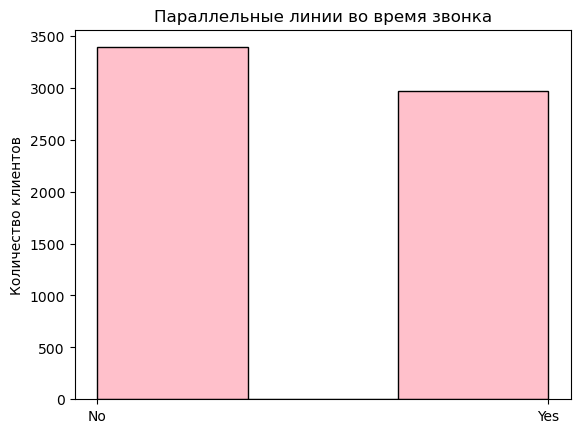

In [51]:
plt.hist(phone['MultipleLines'], color = "pink", bins=3, ec="black", lw= 1);
plt.title('Параллельные линии во время звонка')
plt.ylabel('Количество клиентов');

### Заметки по phone_new

* наличие возможности ведения параллельных линий во время звонка есть примерно у половины клиентов, у которых подключен телефон. Есть еще (7043 - 6361 = 682) клиента, которые видимо не подключали телефон.

## Предварительные выводы

* Необходимо будет соединить все таблицы по customerID, что неизбежно приведет к пропускам, с чем придется работать на следующем этапе
* Основные распределения групп среди клиентов понятны, но основные закономерности увидим только в следущей части, где надо будт смотреть на корреляцию признаков

## План

1. Соединить все датасеты в один
2. Почистить данные от дубликатов (скрытых и нет если они есть)
3. Почистить данные от пропусков, придумать какие заглушки если что ставить
4. Создать целевой признак, и убрать те столбцы которые не будут нужны
5. Визуализация данных
6. Анализ признаков на корреляцию
7. Деление выборок на обучающую и тестовую
8. Кодирование признаков, также можно масштабировать
9. Тестим несколько моделей с разными гиперпараметрами
10. Выбираем лучшую модель с лучшей метрикой и проверяем ее на тестовой выборке
11. Смотрим соответствует ли метрика на тестовой с нашими требованиями
12. Пишем выводы

# Обработка данных и модель

In [52]:
import phik
import networkx as nx
import lightgbm as lgb

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB
from catboost import CatBoostClassifier, Pool

from sklearn.metrics import roc_auc_score
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold

import lifelines as lf

## Подготовка данных

Объединяем данные в один датафрейм

In [53]:
df1 = pd.merge(contract, internet, how='left', left_on='customerID', right_on='customerID')

df2 = pd.merge(df1, personal, how='left', left_on='customerID', right_on='customerID')

df = pd.merge(df2, phone, how='left', left_on='customerID', right_on='customerID')

display(df.head(5))
display(df.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,No,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,Male,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,Male,No,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,Female,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   object 


None

Если в MultipleLines нет какого то id, это значит что нет телефонии. Значит можно добавить новую категорию Notel.

In [54]:
df.loc[df['MultipleLines'].isna()==True, 'MultipleLines'] = 'Notel'

Если нет id в датафрейме про услуги интернета, значит у человека не подключен интернет, тогда можно добавить категорию Noint

In [55]:
df.loc[df['StreamingMovies'].isna()==True, 'StreamingMovies'] = 'Noint'
df.loc[df['StreamingTV'].isna()==True, 'StreamingTV'] = 'Noint'
df.loc[df['TechSupport'].isna()==True, 'TechSupport'] = 'Noint'
df.loc[df['DeviceProtection'].isna()==True, 'DeviceProtection'] = 'Noint'
df.loc[df['OnlineBackup'].isna()==True, 'OnlineBackup'] = 'Noint'
df.loc[df['OnlineSecurity'].isna()==True, 'OnlineSecurity'] = 'Noint'
df.loc[df['InternetService'].isna()==True, 'InternetService'] = 'Noint'

Смотрим на дубикаты

In [56]:
df.duplicated().sum()

0

Создаем новый столбец с целевым признаком, на основе столбца EndDate. Если конечная дата есть - значит человек ушел. Соответственно если нет даты, то клиент действующий.

In [57]:
df['tf'] = np.where(df['EndDate']=='No', '0', '1')

In [58]:
display(df.head(5))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,tf
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,...,No,No,No,No,Female,No,Yes,No,Notel,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,...,Yes,No,No,No,Male,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,...,No,No,No,No,Male,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,...,Yes,Yes,No,No,Male,No,No,No,Notel,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,...,No,No,No,No,Female,No,No,No,No,0


Теперь вычислим сколько на момент создания датасета все клиенты были клиентами, если этот клиент ушел, тогда просто вычтем из конечной даты начальную, если клиент действующий то вычтем из 2020-02-01 начальную дату.

In [59]:
df.loc[df['EndDate']=='No', 'EndDate'] = '2020-02-01'

df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')

df['durcon'] = df['EndDate'] - df['BeginDate']

In [60]:
display(df.head(5))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,tf,durcon
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,...,No,No,No,Female,No,Yes,No,Notel,0,31 days
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,DSL,Yes,...,No,No,No,Male,No,No,No,No,0,1036 days
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,...,No,No,No,Male,No,No,No,No,0,123 days
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,...,Yes,No,No,Male,No,No,No,Notel,0,1371 days
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,...,No,No,No,Female,No,No,No,No,0,153 days


Переведем этот столбец в нужный формат чтобы получить просто количество дней числом

In [61]:
df['durcon'] = df['durcon'].astype('timedelta64[D]')

In [62]:
df['durcon'] = df['durcon'].astype('int')

In [63]:
display(df.head(5))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,tf,durcon
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,...,No,No,No,Female,No,Yes,No,Notel,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,DSL,Yes,...,No,No,No,Male,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,...,No,No,No,Male,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,...,Yes,No,No,Male,No,No,No,Notel,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,...,No,No,No,Female,No,No,No,No,0,153


Теперь удаляем столбцы с датой

In [64]:
df = df.drop('BeginDate', axis=1) 
df = df.drop('EndDate', axis=1) 

Сделаем id клиента индексом 

In [65]:
df = df.set_index('customerID')

Теперь я хочу посмотреть распределение нашего столбца с количеством дней, которые клиенты провели с компанией

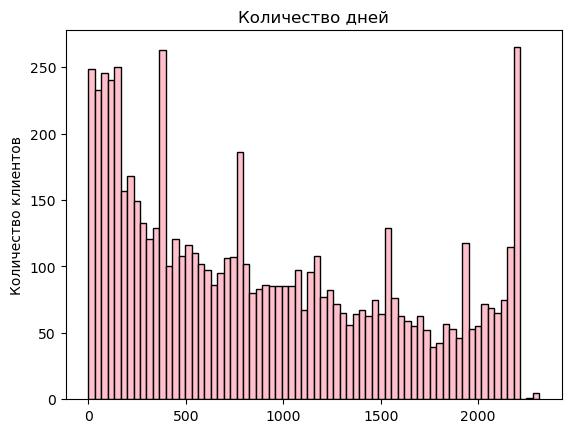

In [66]:
plt.hist(df['durcon'], color = "pink", bins=70, ec="black", lw= 1);
plt.title('Количество дней')
plt.ylabel('Количество клиентов');

## Анализ

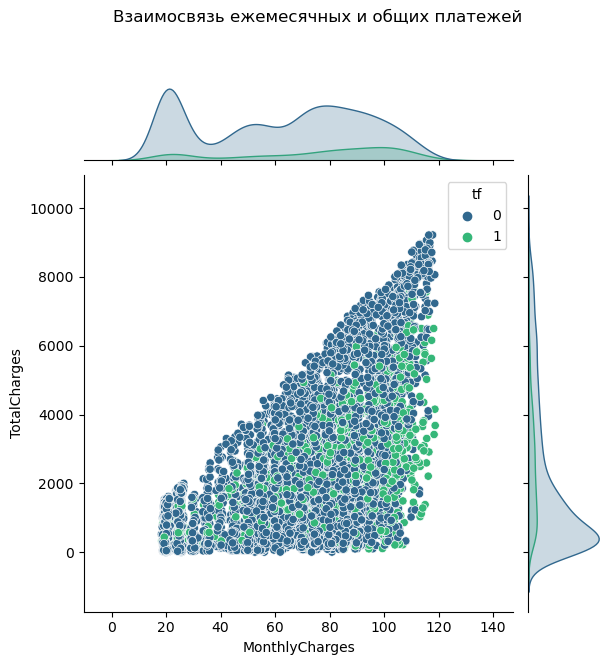

In [67]:
sns.jointplot(data=df, x="MonthlyCharges", y="TotalCharges", hue="tf", legend=True, palette='viridis')
plt.suptitle('Взаимосвязь ежемесячных и общих платежей', x=0.5, y=1.1);

* количество ушедших клиентов больше всего среди тех, кто заплатил всего в диапазоне от 0 до 2000 у.е
* два пика ушедших в зависимости от MonthlyCharges: кто платит в месяц 20 у.е и растет в диапазоне от 70 до 100 у.е
* в левом верхнем углу у нас те, кто давно с нами, их подписка стоит меньше всего, но есть те кто в общем заплатил уже около 2000
* в правом верхнем углу у нас те, кто платит ежемесячно больше всех и при этом является клиентом уже продолжительное время
* в левом верхнем и в правом верхнем углу почти нет тех, кто ушел

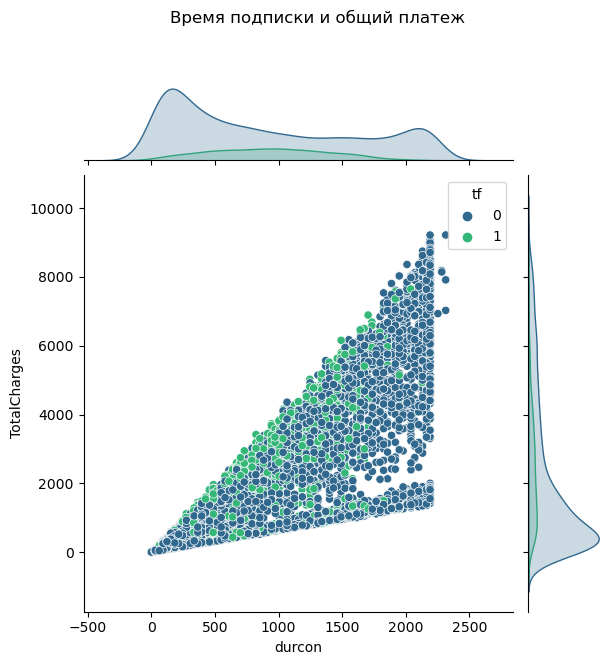

In [68]:
sns.jointplot(data=df, x="durcon", y="TotalCharges", hue="tf", legend=True, palette='viridis')
plt.suptitle('Время подписки и общий платеж', x=0.5, y=1.1);

* больше всего ушедших клиентов были клиентами от 250 до 1250 дней, до этого и после этого периода их меньше, сначала слегка растет, потом спадает.
* если клиент является действующим более 1750 дней он редко уходит
* причем чем больше TotalCharges, тем менее вероятно что клиент уйдет.

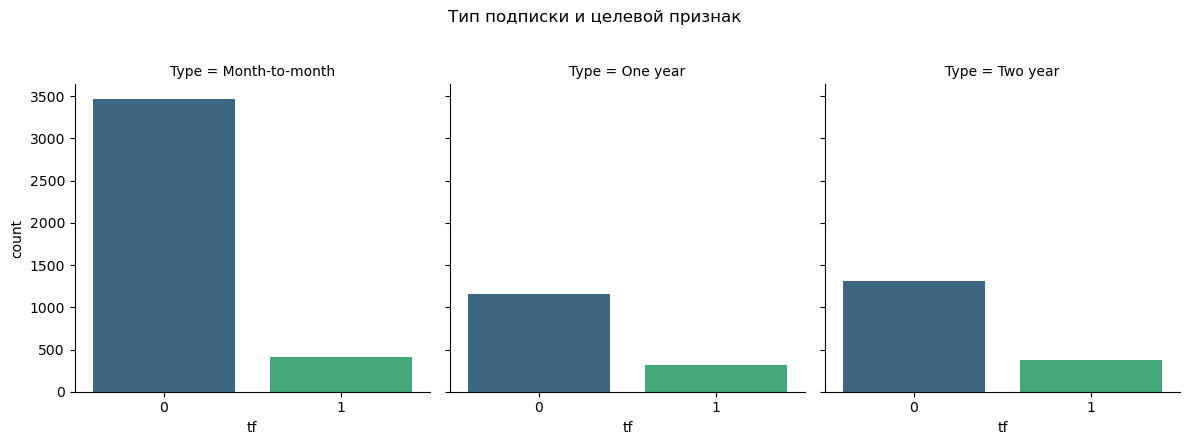

In [69]:
g = sns.catplot(x="tf", col="Type", col_wrap=3,
                data=df,
                kind="count", height=4, 
                palette='viridis')
plt.suptitle('Тип подписки и целевой признак', x=0.5, y=1.1)
plt.show();

* Больше всего действующих клиентов которые выбрали помесячную оплату
* среди тех кто платит ежемесячно меньше всего в процентном соотношении ушедших
* людей которые имеют договор на два года чуть большем чем на один год, но и ушедших тоже больше и явно больше в процентах, чем среди тех кто платит ежемесячно

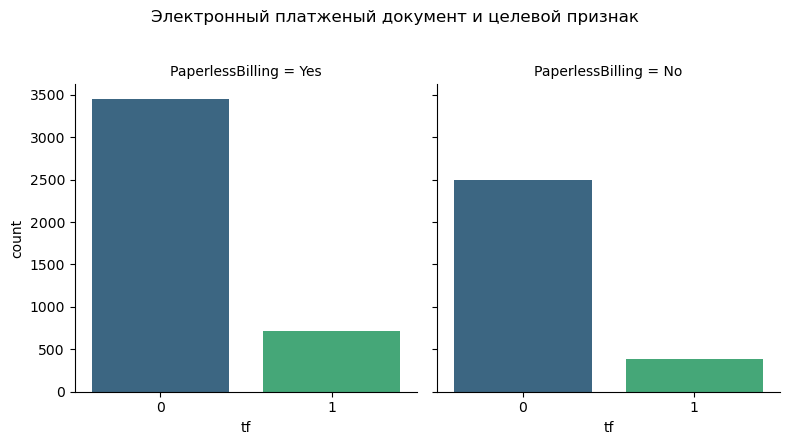

In [70]:
g = sns.catplot(x="tf", col="PaperlessBilling", col_wrap=2,
                data=df,
                kind="count", height=4, 
                palette='viridis')
plt.suptitle('Электронный платженый документ и целевой признак', x=0.5, y=1.1)
plt.show();

* электронный платежный документ (эпд) получает большая часть клиентов
* связи какой то с тем есть этот эпд у клиента или нет не замечается

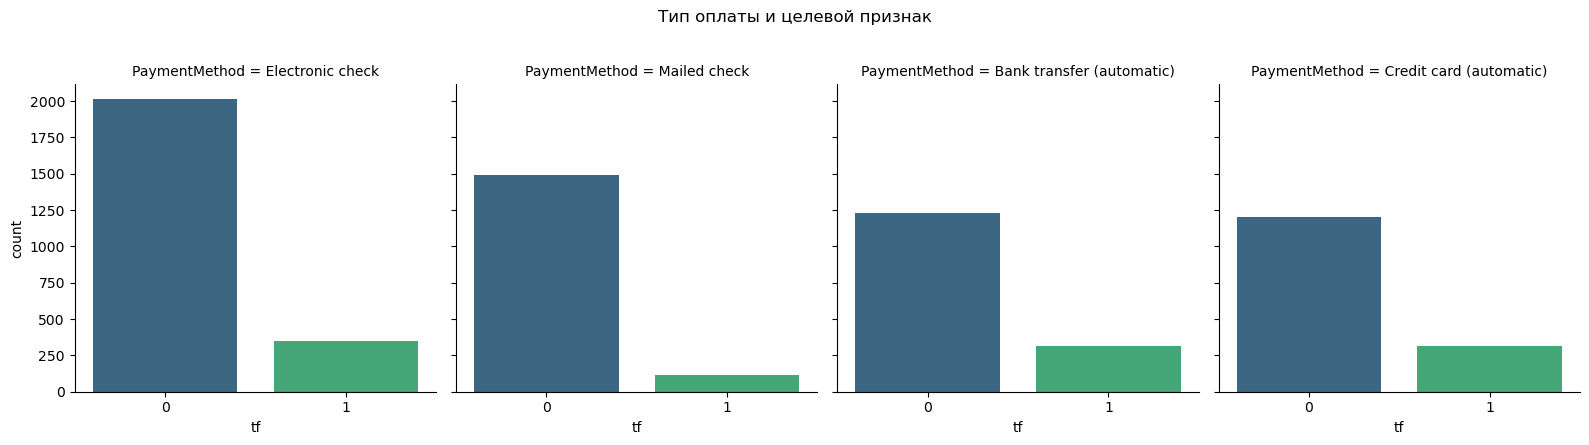

In [71]:
g = sns.catplot(x="tf", col="PaymentMethod", col_wrap=4,
                data=df,
                kind="count", height=4, 
                palette='viridis')
plt.suptitle('Тип оплаты и целевой признак', x=0.5, y=1.1)
plt.show();

* большая часть клиентов предпочитают тип оплаты электронным чеком
* среди тех, кто платит по почте меньше всего покинувших клиентов
* прмерно равнозначные количества платят обоими автоматическими методами 
* количество покинувших клиентов одинаково среди автоматических методов оплаты
* при этом среди тех, кто платит электронным чеком количество ушедших такое же как среди автоматических методов оплаты
* видимо клиентов кто платит по автоматической подписке клиенты чаще уходят, может это связано с возрастом клиентов, так как такие родвинутые методы оплаты в основном распространены среди молодых

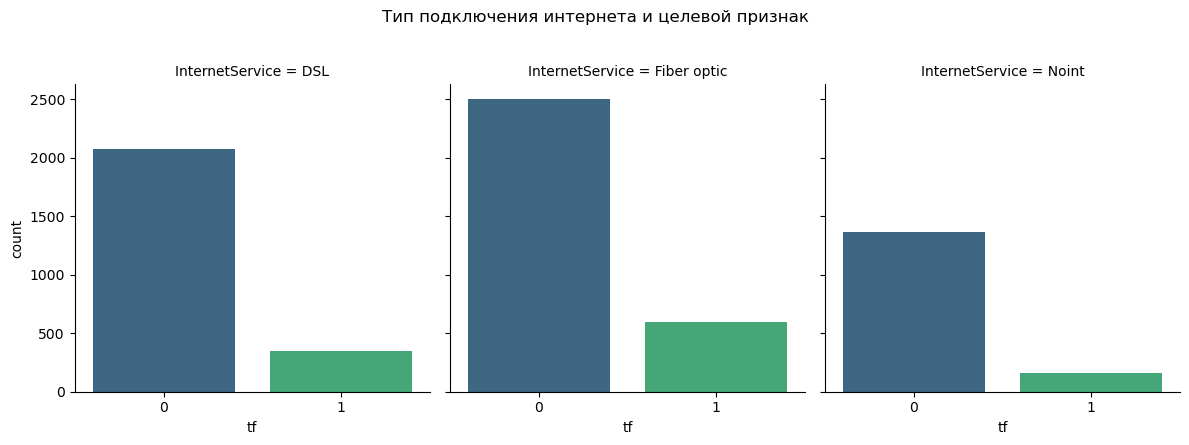

In [72]:
g = sns.catplot(x="tf", col="InternetService", col_wrap=3,
                data=df,
                kind="count", height=4, 
                palette='viridis')
plt.suptitle('Тип подключения интернета и целевой признак', x=0.5, y=1.1)
plt.show();

* Больше всего клиентов подключены через Fiber optic, но и клиентов ушедших тоже больше всего среди них же
* Меньшинство клиентов не подключены к интернету, но и клиентов ушедших тоже меньше всего в абсолютных значениях

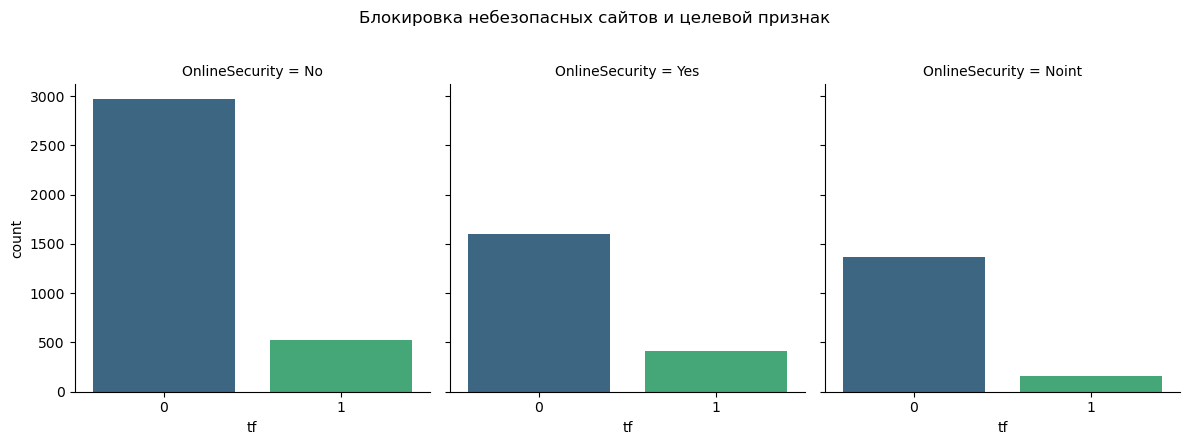

In [73]:
g = sns.catplot(x="tf", col="OnlineSecurity", col_wrap=3,
                data=df,
                kind="count", height=4, 
                palette='viridis')
plt.suptitle('Блокировка небезопасных сайтов и целевой признак', x=0.5, y=1.1)
plt.show();

* Большинство клиентов не подключены к блокировке небезопасных сайтов
* Большинство ушедших клиентов среди тех у кого не подключена безопасность сайтов
* в относительных же значениях, меньше всего ушедших среди тех кто вообще не поделючал интернет (в данном разрезе)

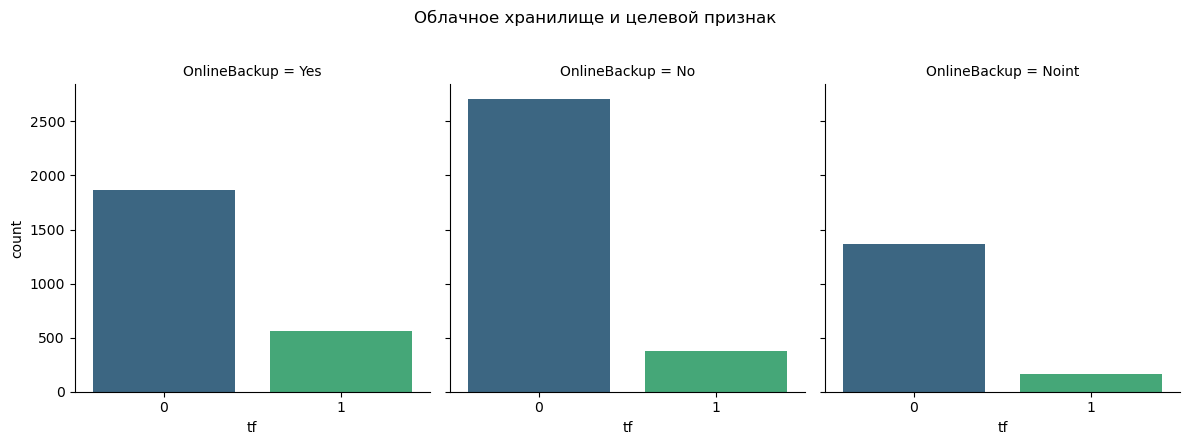

In [74]:
g = sns.catplot(x="tf", col="OnlineBackup", col_wrap=3,
                data=df,
                kind="count", height=4, 
                palette='viridis')
plt.suptitle('Облачное хранилище и целевой признак', x=0.5, y=1.1)
plt.show();

* Больше всего клиентов не подключало облачное хранилище
* среди тех, кто не подключал ОХ, очень небольшое число тех кто ушел 
* Относительно большая группа ушедших клиентов среди тех, кто подключал облачное хранилище
* меньше всего ушедших клиентов среди тех кто вообще не подключал интернет 

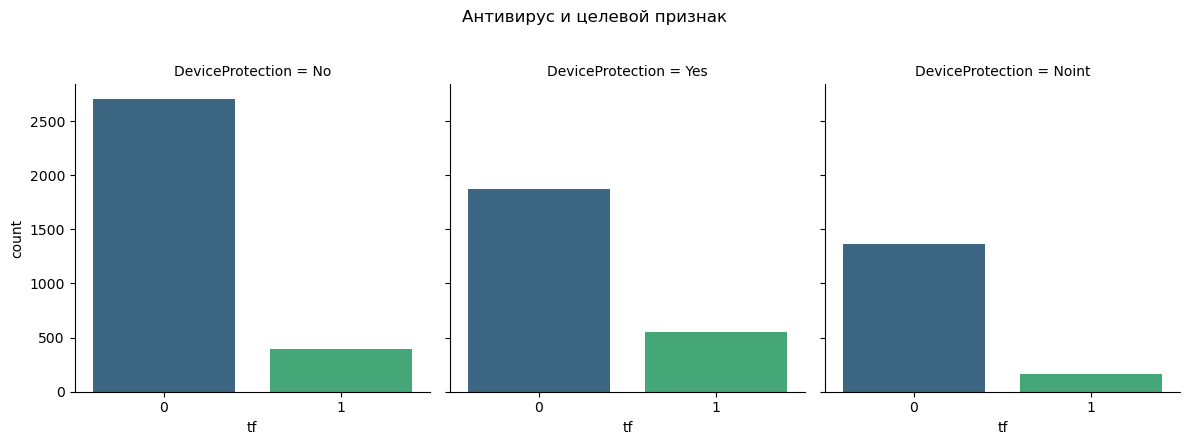

In [75]:
g = sns.catplot(x="tf", col="DeviceProtection", col_wrap=3,
                data=df,
                kind="count", height=4, 
                palette='viridis')
plt.suptitle('Антивирус и целевой признак', x=0.5, y=1.1)
plt.show();

* больше всего клиентов не подключало антивирус
* среди тех кто не подключал антивирус мало тех клиентов, кто ушел 
* больше всего ушедших среди сравнительно небольшой группы людей, у которых антивирус подключен 
* меньше всего ушедших клиентов среди тех, кто не подключал интернет вообще, но это в абсолютных значениях

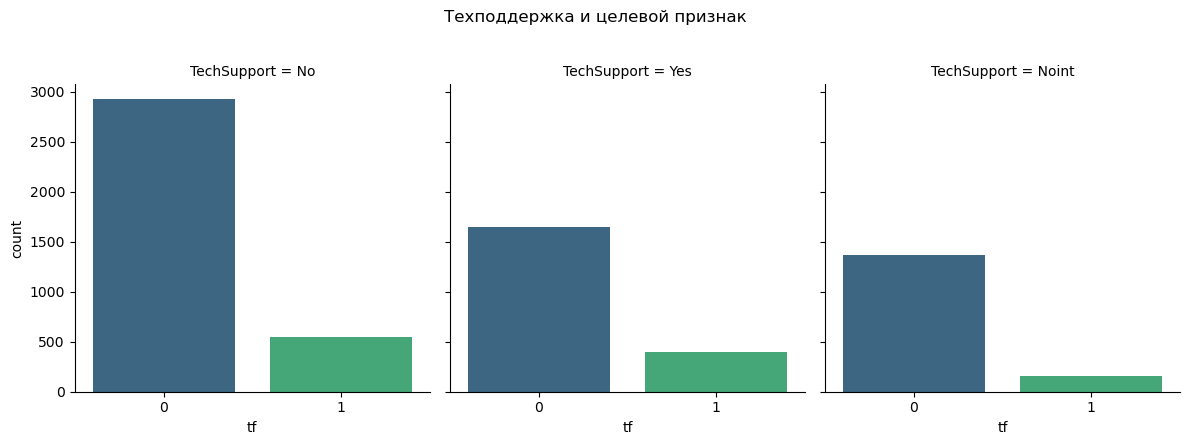

In [76]:
g = sns.catplot(x="tf", col="TechSupport", col_wrap=3,
                data=df,
                kind="count", height=4, 
                palette='viridis')
plt.suptitle('Техподдержка и целевой признак', x=0.5, y=1.1)
plt.show();

* большинстыо клиентов не подкключает техподдержку, среди них больше всего клиентов которые ушли
* средний показатель и подключивших техподдержку и ушедших клиентов 
* меньшинство клиентов не подключили интернет и при этом меньше всего ушли 

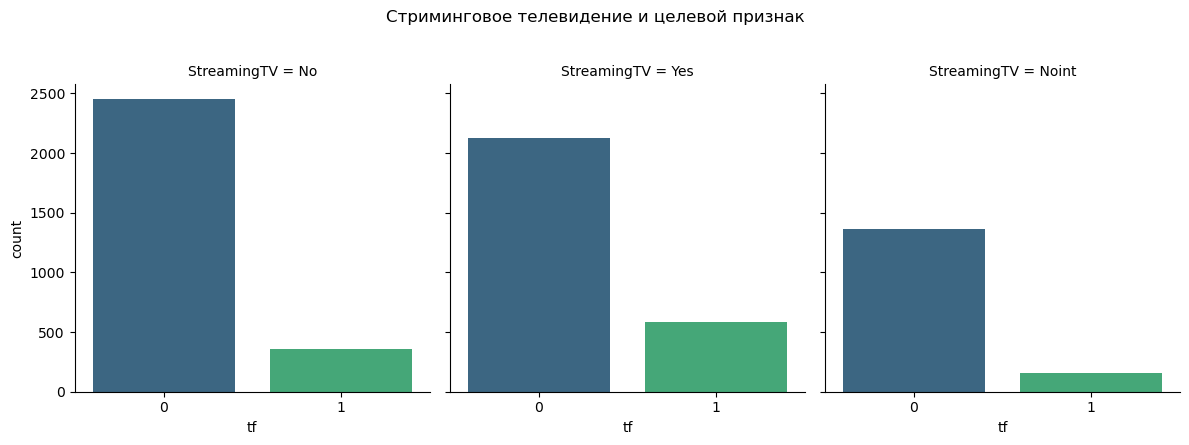

In [77]:
g = sns.catplot(x="tf", col="StreamingTV", col_wrap=3,
                data=df,
                kind="count", height=4, 
                palette='viridis')
plt.suptitle('Стриминговое телевидение и целевой признак', x=0.5, y=1.1)
plt.show();

* большинство клиентов не имеет подключаения к стриминковому тв
* больше всего коиентов ушло из группы у кого подключено стрминговое тв
* меньше всего ушло людей из группы тех, кто вообще не подключал интернет услуги

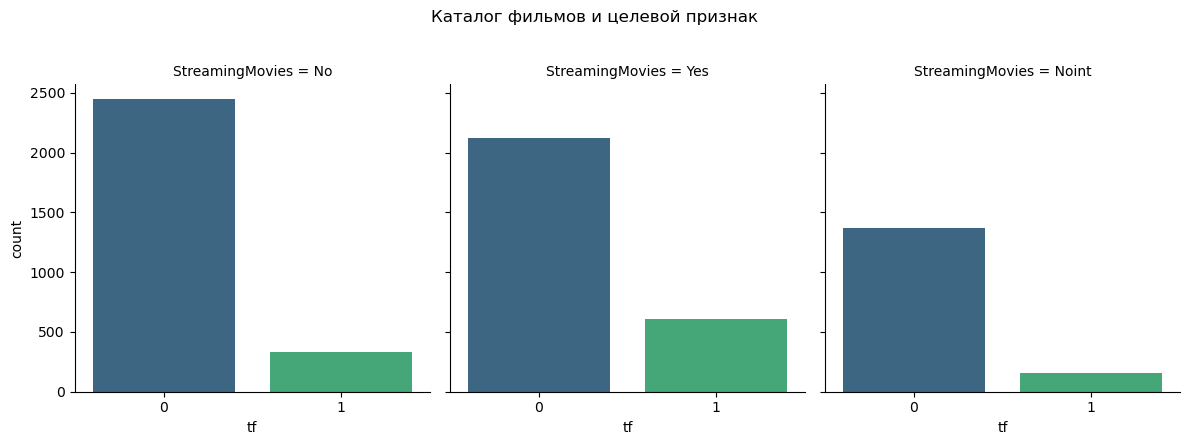

In [78]:
g = sns.catplot(x="tf", col="StreamingMovies", col_wrap=3,
                data=df,
                kind="count", height=4, 
                palette='viridis')
plt.suptitle('Каталог фильмов и целевой признак', x=0.5, y=1.1)
plt.show();

* те у кого подключен каталог филльмов имеет больше всего ушедших клиентов
* меньше всего ушло клиентов из группы тех кто не подключал интернет
* в относительном отношении неболшое количество клиентов ушло из группы тех, кто не подключал каталог фильмов и при этом имеет услугу интернета

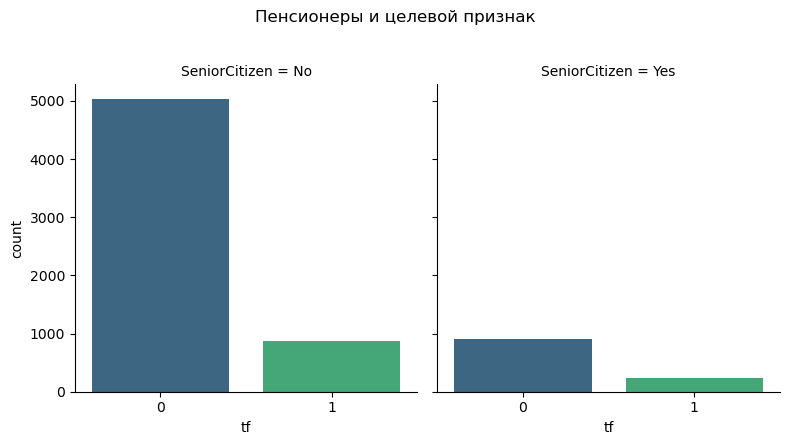

In [79]:
g = sns.catplot(x="tf", col="SeniorCitizen", col_wrap=2,
                data=df,
                kind="count", height=4, 
                palette='viridis')
plt.suptitle('Пенсионеры и целевой признак', x=0.5, y=1.1)
plt.show();

* большинство клиентов не пенсионеры
* среди пенсионеров не так много тех кто ушел, но это в абсолютных значениях
* в относительном значении пенсионеры перестают быть клиентами чаще чем не песионеров

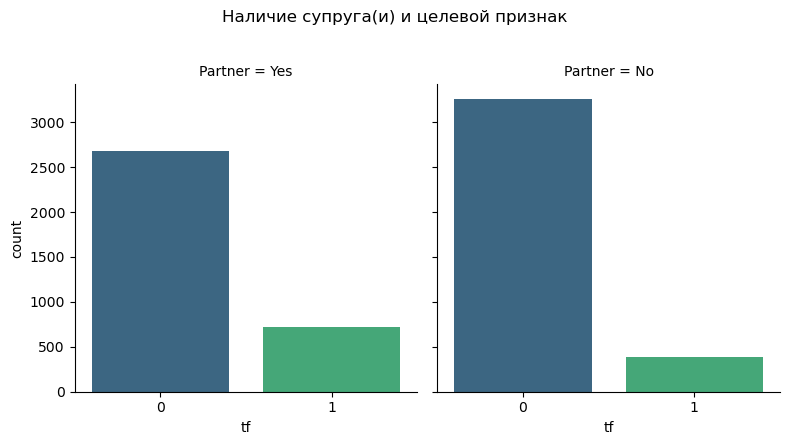

In [80]:
g = sns.catplot(x="tf", col="Partner", col_wrap=2,
                data=df,
                kind="count", height=4, 
                palette='viridis')
plt.suptitle('Наличие супруга(и) и целевой признак', x=0.5, y=1.1)
plt.show();

* большинство клиентов не имеет супрга
* среди тех у кого есть супруги больше тех кто ушел, по сравнению с группой тех у кого супругов нет 
* очень мало ушедших кклиентов среди тех, кто не имеет супруга

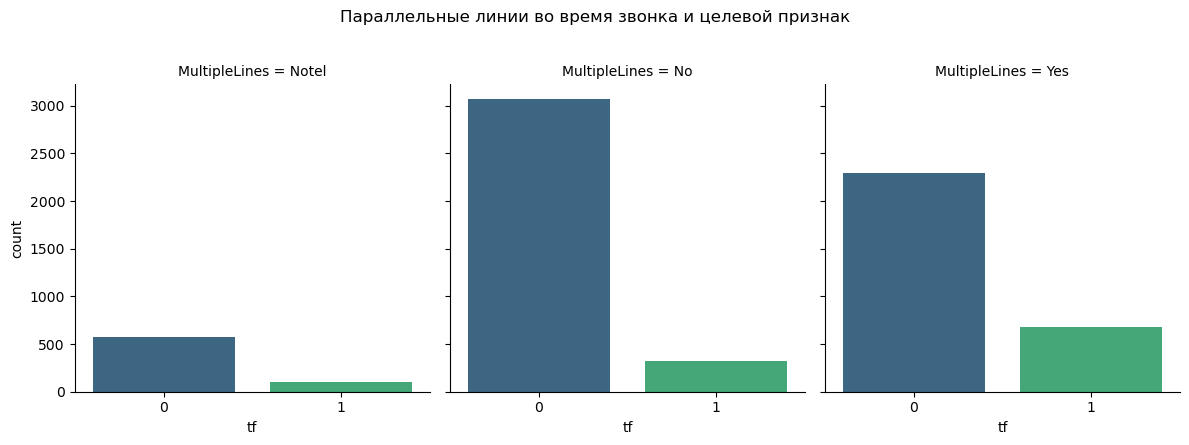

In [81]:
g = sns.catplot(x="tf", col="MultipleLines", col_wrap=3,
                data=df,
                kind="count", height=4, 
                palette='viridis')
plt.suptitle('Параллельные линии во время звонка и целевой признак', x=0.5, y=1.1)
plt.show();

* очень мало клиентов не подключены к интернету, среди них мало тех кто ушел
* больше всего клиентов не подключены к параллельным линиям
* среди тех, кто не подключен к параллельным линиям мало тех, кто ушел
* очень много в относительном отношении тех, кто ушел среди тех у кого подключены параллельные линии

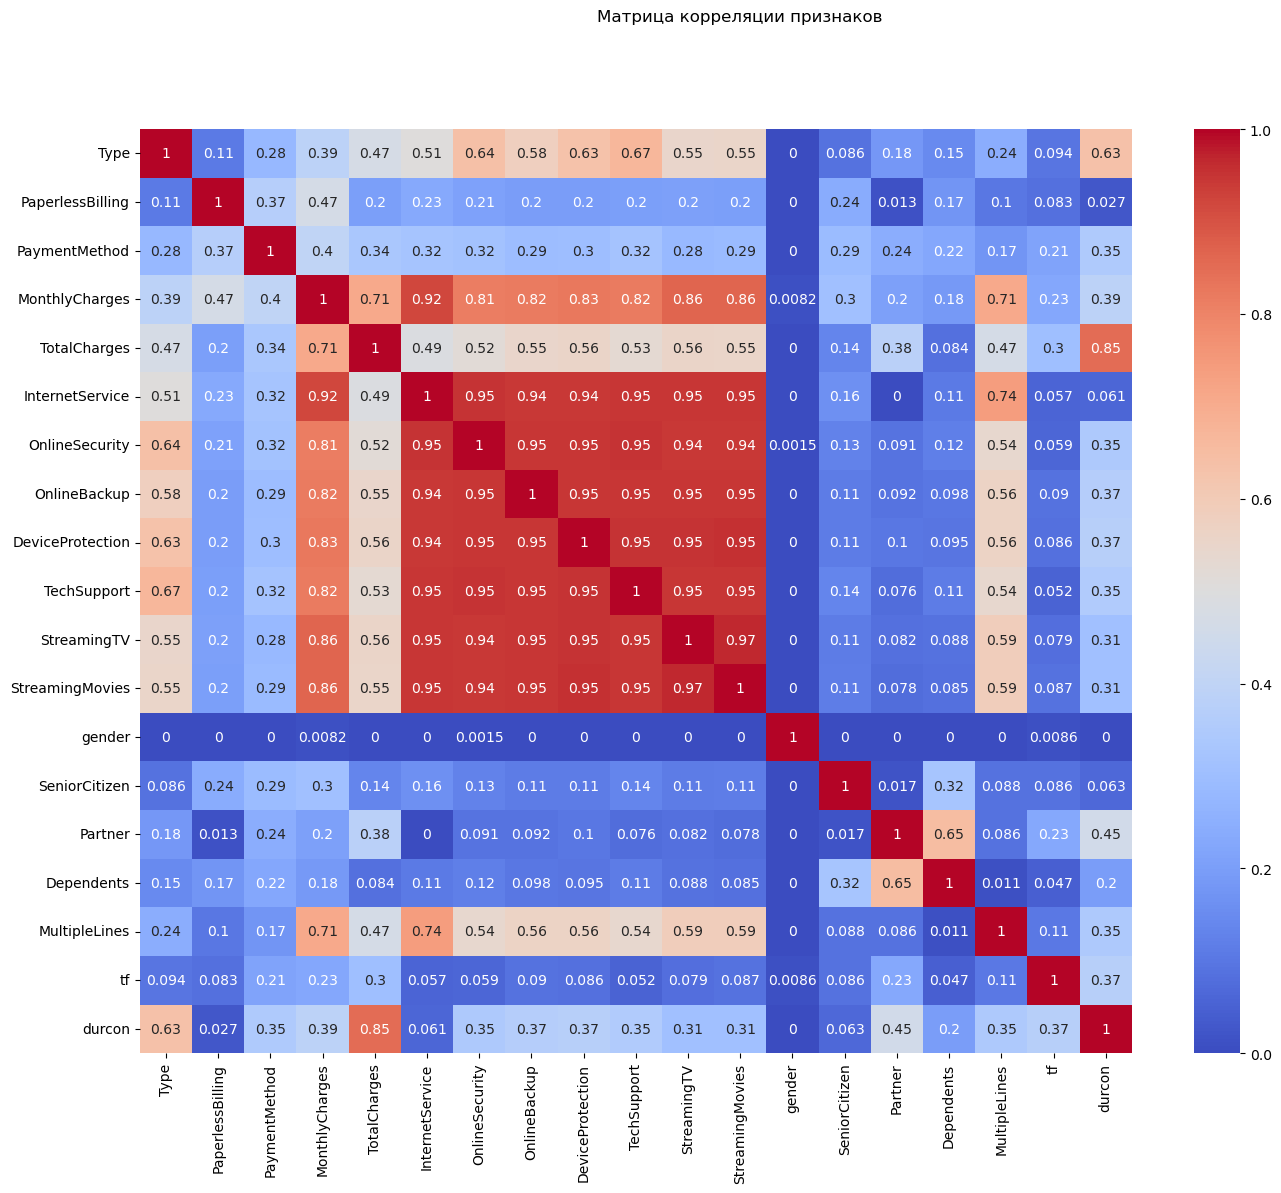

In [82]:
int_cols = ['MonthlyCharges', 'TotalCharges', 'durcon']

matrix = df.phik_matrix(interval_cols=int_cols)
plt.figure(figsize=(16,12))
plt.suptitle('Матрица корреляции признаков')
sns.heatmap(matrix, cmap="coolwarm", annot=True)
plt.show();

Из матрицы видно несколько вещей, целевой признак(tf) не показывает очень сильной зависимости ни от одного признака, но немного связана с длиной времени договора, и от общих трат за все время. Дни договора клиентов (durcon) имеет зависимость с общими тратами (total charges), тип подписки, и наличие супруга(и), с остальными не так сильна взаимосвязь.

Еще видно, что в целом признак пола можно убрать из таблицы чтобы было поменьше признаков, потому что судя по матрице пол не влияет буквально ни на что

И можно убрать иждивенцев, на tf это не имеет никакого влияния

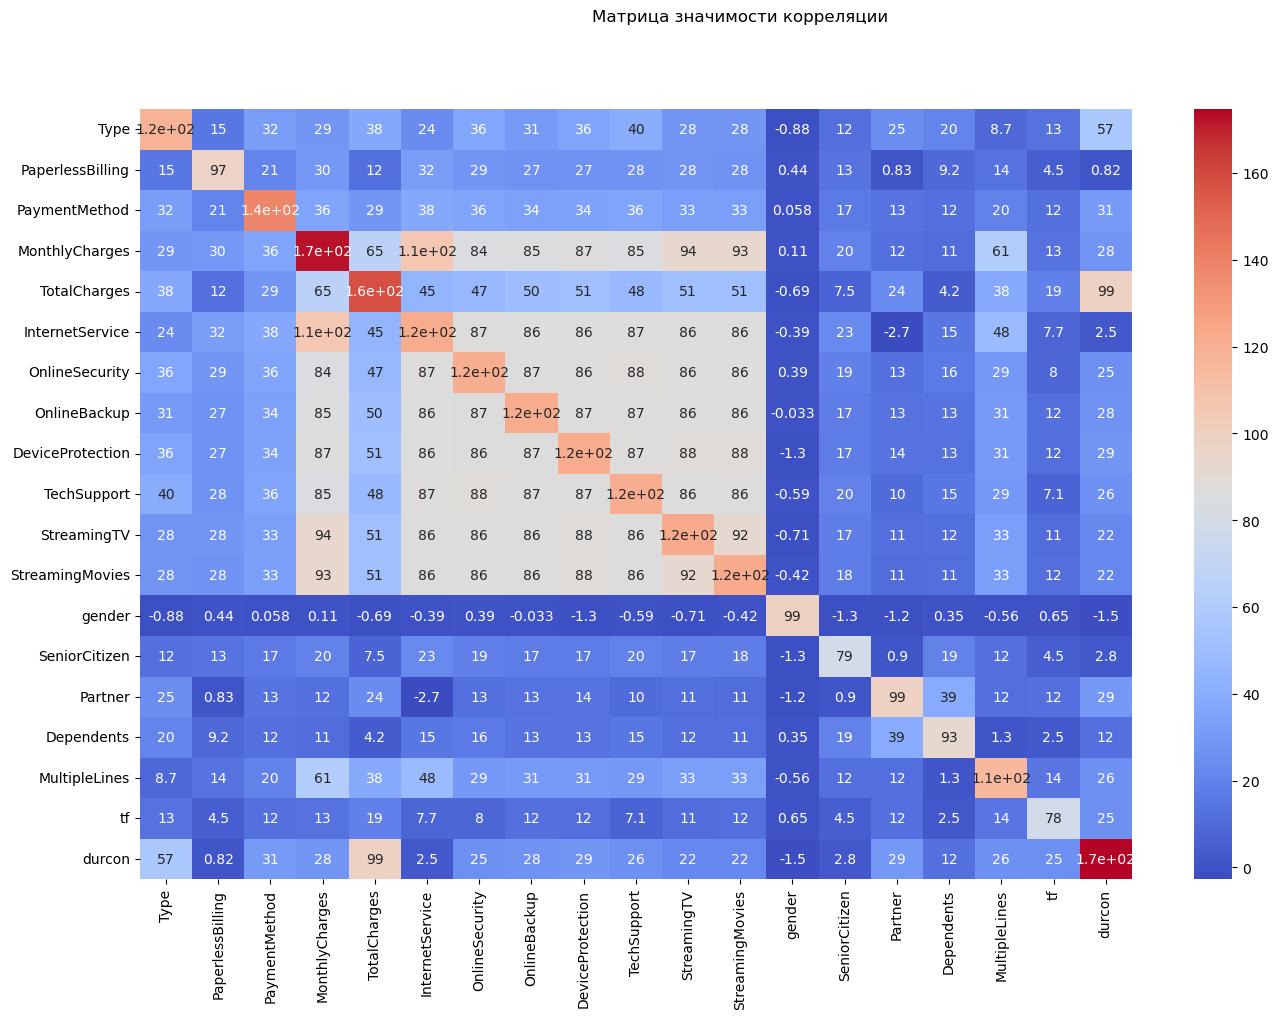

In [83]:
sig_matrix = df.significance_matrix(interval_cols=int_cols)
plt.figure(figsize=(16, 10))
plt.suptitle('Матрица значимости корреляции')
sns.heatmap(sig_matrix, cmap="coolwarm", annot=True)
plt.show();

significance_matrix - это матрица, которая показывает значимость корреляции между парами признаков в данных. Корреляции, которые значимо отличаются от случайных сочетаний, имеют более высокие значения.

* По данной таблице видно что значимость влияния durcon на tf всего 25, это очень немного, но она все же есть
* сильная значимость есть у total charges и durcon, что логично чем дольше человек имеет активную подписку, тем больше он всего заплатил
* блок доп услуг по интернету имеет достаточно значимую зависимость друг от друга 
* высокая значимость между ежемесячной оплатой и подключения услуги интернета
* подкючение параллельных линий имеет несколько значимых кореляций с ежемесячной оплатой и подключением интернета

Поскокльку пол не коррелирует вообще ни с чем этот столбец можно удалить и посмотреть как модель обучится без этого признака
И корреляция самая самая низкая у целевого признака с наличием иждивенцев, его тоже можно дропнуть чтобы было поменьше признаков

In [84]:
df = df.drop('gender', axis=1) 
df = df.drop('Dependents', axis=1) 

In [85]:
df.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'SeniorCitizen', 'Partner', 'MultipleLines', 'tf', 'durcon'],
      dtype='object')

Разбиваем данные на выборки

In [86]:
train, test = train_test_split(df, test_size=0.25, stratify=df['tf'], random_state=RANDOM_STATE)

In [87]:
f_train = train.drop('tf', axis = 1)
t_train = train['tf']

f_test = test.drop('tf', axis = 1)
t_test = test['tf']

Кодируем признаки

In [88]:
categorical_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', \
                       'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',\
                       'SeniorCitizen', 'Partner','MultipleLines']
numeric_columns = ['MonthlyCharges','TotalCharges','durcon']

encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
encoder.fit(f_train[categorical_columns])

OneHotEncoder(drop='first', handle_unknown='ignore')

In [89]:
f_train_encoded = pd.DataFrame(
    encoder.transform(f_train[categorical_columns]).toarray(),
    columns=encoder.get_feature_names_out(categorical_columns),
    index=f_train.index)
f_train = pd.concat((f_train[numeric_columns], f_train_encoded), axis=1)
    
f_test_encoded = pd.DataFrame(
    encoder.transform(f_test[categorical_columns]).toarray(),
    columns=encoder.get_feature_names_out(categorical_columns),
    index=f_test.index
)
f_test = pd.concat((f_test[numeric_columns], f_test_encoded), axis=1)

Смотрим на итоговые размерности выборок

In [90]:
print(f_train.shape, f_test.shape)

(5282, 27) (1761, 27)


Смотрим на количество уникальных значения в столбцах

In [91]:
display(f_train.nunique(), f_test.nunique())

MonthlyCharges                           1463
TotalCharges                             5063
durcon                                    241
Type_One year                               2
Type_Two year                               2
PaperlessBilling_Yes                        2
PaymentMethod_Credit card (automatic)       2
PaymentMethod_Electronic check              2
PaymentMethod_Mailed check                  2
InternetService_Fiber optic                 2
InternetService_Noint                       2
OnlineSecurity_Noint                        2
OnlineSecurity_Yes                          2
OnlineBackup_Noint                          2
OnlineBackup_Yes                            2
DeviceProtection_Noint                      2
DeviceProtection_Yes                        2
TechSupport_Noint                           2
TechSupport_Yes                             2
StreamingTV_Noint                           2
StreamingTV_Yes                             2
StreamingMovies_Noint             

MonthlyCharges                            933
TotalCharges                             1741
durcon                                    181
Type_One year                               2
Type_Two year                               2
PaperlessBilling_Yes                        2
PaymentMethod_Credit card (automatic)       2
PaymentMethod_Electronic check              2
PaymentMethod_Mailed check                  2
InternetService_Fiber optic                 2
InternetService_Noint                       2
OnlineSecurity_Noint                        2
OnlineSecurity_Yes                          2
OnlineBackup_Noint                          2
OnlineBackup_Yes                            2
DeviceProtection_Noint                      2
DeviceProtection_Yes                        2
TechSupport_Noint                           2
TechSupport_Yes                             2
StreamingTV_Noint                           2
StreamingTV_Yes                             2
StreamingMovies_Noint             

## Модели

In [92]:
est1 = RandomForestClassifier(random_state=RANDOM_STATE)

p1 = {}
p1['classifier__n_estimators'] = [20, 50, 100, 350]
p1['classifier__max_depth'] = [10, 20, 50, 100, 150]
p1['classifier'] = [est1]

In [93]:
est2 = LogisticRegression(random_state=RANDOM_STATE)

p2 = {}
p2['classifier__C'] = [0.01, 0.1, 1, 3]
p2['classifier__max_iter'] = [50, 100, 150, 300]
p2['classifier'] = [est2]

In [94]:
est3 = DecisionTreeClassifier(random_state=RANDOM_STATE)

p3 = {}
p3['classifier__max_depth'] = [10, 30, 50, 150, 300]
p3['classifier__min_samples_split'] = [2,5,10]
p3['classifier'] = [est3]

In [95]:
est4 = CategoricalNB()

p4 = {}
p4['classifier__alpha'] = [0.0, 1.0]
p4['classifier'] = [est4]

In [96]:
est5 = lgb.LGBMClassifier(random_state=RANDOM_STATE)

p5 = {}
p5['classifier__max_depth'] = [1, 2, 3, 4, 5, 10, 70, 150]
p5['classifier__n_estimators'] = [100, 200, 300, 500]
p5['classifier__learning_rate'] = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]
p5['classifier'] = [est5]

In [97]:
est6 = CatBoostClassifier(random_state=RANDOM_STATE)

p6 = {}
p6['classifier__iterations'] = [120, 200, 350]
p6['classifier__learning_rate'] = [0.01, 0.1, 0.3, 0.5]
p6['classifier'] = [est6]

In [98]:
pipeline = Pipeline([('classifier', est1)])
params = [p1, p2, p3, p4, p5, p6]

Далее: обучение моделей

In [99]:
skf = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
skf

StratifiedKFold(n_splits=5, random_state=80523, shuffle=True)

In [100]:
gridsearch = GridSearchCV(pipeline, params, cv=skf, n_jobs=-1, scoring='roc_auc').fit(f_train, t_train)

C:\Users\murat\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.81847721 0.82764845 0.83201599 0.83494126 0.79696002 0.81137139
 0.81700862 0.81890284 0.79096221 0.81116701 0.81536023 0.81719898
 0.79096221 0.81116701 0.81536023 0.81719898 0.79096221 0.81116701
 0.81536023 0.81719898 0.70594835 0.75910918 0.75503777 0.75283018
 0.70067122 0.76580783 0.76718831 0.76772403 0.68292129 0.76731621
 0.76907511 0.76949533 0.68395215 0.76751459 0.76914552 0.76960402
 0.73176943 0.7441911  0.74944838 0.64230213 0.66782223 0.69916734
 0.64230213 0.66782223 0.69916734 0.64230213 0.66782223 0.69916734
 0.64230213 0.66782223 0.69916734        nan        nan 0.77076385
 0.79192503 0.80349128 0.81435324 0.8033126  0.81849149 0.82486335
 0.83078579 0.8151699  0.82369489 0.82955837 0.83587755 0.82069614
 0.82909016 0.83394064 0.83923097 0.82089137 0.82846633 0.833021
 0.83844964 0.82542327 0.83472202 0.83834575 0.84391641

In [101]:
gridsearch.best_params_

{'classifier': LGBMClassifier(learning_rate=0.5, max_depth=2, n_estimators=500,
                random_state=80523),
 'classifier__learning_rate': 0.5,
 'classifier__max_depth': 2,
 'classifier__n_estimators': 500}

In [102]:
gridsearch.best_score_

0.9119630416388477

Лучшая модель: LGBMClassifier(learning_rate=0.5, max_depth=2, n_estimators=500,
                random_state=80523)

Значение ROC-AUC на ней: 0.9119630416388477

In [103]:
pred_test = gridsearch.predict_proba(f_test)
pred_one_test = pred_test[:,1]

In [104]:
test_roc_auc = roc_auc_score(t_test, pred_one_test)

print('ROC-AUC на тестовой:', test_roc_auc)

ROC-AUC на тестовой: 0.906271870794078


ROC-AUC на тестовой: 0.906271870794078

In [105]:
model = lgb.LGBMClassifier(learning_rate=0.7, max_depth=2, n_estimators=300, random_state=RANDOM_STATE)

model.fit(f_train, t_train)
pred = model.predict(f_test)

Раз я решила вытащить feature_importances_ то можно и еще раз метрики проверить

In [106]:
acc = accuracy_score(t_test, pred)

print('accuracy_score:', acc)

accuracy_score: 0.9176604202157865


Accuracy score равен 0.9176604202157865

In [107]:
pd.DataFrame({'Value':model.feature_importances_,'Feature':f_train.columns}).sort_values(by="Value",ascending=False).head()

,Value,Feature
2,426,durcon
1,194,TotalCharges
0,156,MonthlyCharges
24,15,Partner_Yes
3,13,Type_One year


Наиболее значимые признаки для модели следующие:
* продолжительность контракта
* общая сумма трат 
* ежемесячная плата
* с большим отставанием в значимости влияет наличие супруга и тип подписки

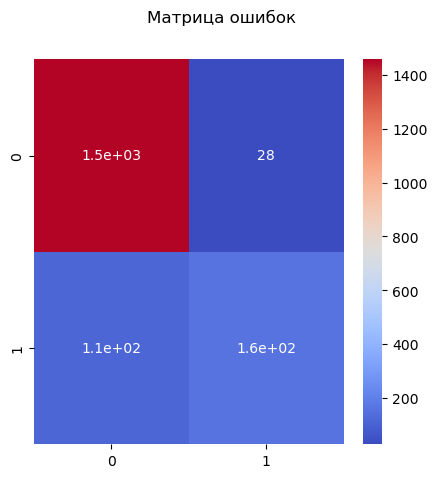

In [108]:
conf_mtx = confusion_matrix(t_test, gridsearch.predict(f_test))
plt.figure(figsize=(5, 5))
plt.suptitle('Матрица ошибок')
sns.heatmap(conf_mtx, cmap="coolwarm", annot=True)
plt.show();

В итоге: True Negative предсказываются прекрасно, True Positive хоть и не прекрасно, но их все же больше чем False Positive. 

### lifelines

Захотелось проверить одну интересную модель, но для этого надо будет немного преобразовать датафрейм

Для этого надо убрать все нули из столбца дней, так как эта модель имеет логарифмическую функцию

In [109]:
df_ll = f_train.merge(t_train, left_on='customerID', right_on='customerID')

df_ll['durcon'] = df_ll['durcon'] + 0.001

In [110]:
surv = lf.WeibullAFTFitter()

surv.fit(df = df_ll, duration_col = 'durcon', event_col = 'tf')

C:\Users\murat\anaconda3\lib\site-packages\lifelines\fitters\__init__.py:2075: ApproximationWarning: The Hessian was not invertible. We will instead approximate it using the pseudo-inverse.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

Some ways to possible ways fix this:

0. Are there any lifelines warnings outputted during the `fit`?
1. Does a particularly large variable need to be centered to 0?
2. Inspect your DataFrame: does everything look as expected? Do you need to add/drop a constant (intercept) column?
3. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
4. Trying adding a small penalizer (or changing it, if already present). Example: `WeibullAFTFitter(penalizer=0.01).fit(...)`.
5. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.

  warnings.warn(warning_text, exceptions.ApproximationWarning)


<lifelines.WeibullAFTFitter: fitted with 5282 total observations, 4456 right-censored observations>

In [111]:
surv.print_summary()

<lifelines.WeibullAFTFitter: fitted with 5282 total observations, 4456 right-censored observations>
             duration col = 'durcon'
                event col = 'tf'
   number of observations = 5282
number of events observed = 826
           log-likelihood = -6647.64
         time fit was run = 2023-07-12 16:41:45 UTC

---
                                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                     
lambda_ DeviceProtection_Noint                  0.05       1.05       0.02             0.00             0.09                 1.00                 1.10
        DeviceProtection_Yes                   -0.06       0.94       0.04            -0.13             0.01                 0.88                 1.01
        InternetService_Fiber optic            -0.11       0.90       0.16            -0.42             0.20                 0.66                 1.23
        InternetService_Noint                   0.05       1.05       0.02             0.00             0.09                 1.00                 1.10
        MonthlyCharges                         -0.01       0.99       0.01            -0.03            -0.00                 0.97                 1.00
        MultipleLines_Notel                     0.03       1.03       0.13            -0.23             0.28                 0.80                 1.33
        MultipleLines_Yes                      -0.11       0.89       0.04            -0.18            -0.04                 0.83                 0.96
        OnlineBackup_Noint                      0.05       1.05       0.02             0.00             0.09                 1.00                 1.10
        OnlineBackup_Yes                       -0.09       0.91       0.04            -0.16            -0.02                 0.85                 0.98
        OnlineSecurity_Noint                    0.05       1.05       0.02             0.00             0.09                 1.00                 1.10
        OnlineSecurity_Yes                     -0.05       0.96       0.04            -0.12             0.03                 0.89                 1.03
        PaperlessBilling_Yes                   -0.03       0.97       0.02            -0.07            -0.00                 0.93                 1.00
        Partner_Yes                            -0.08       0.92       0.02            -0.11            -0.05                 0.89                 0.95
        PaymentMethod_Credit card (automatic)  -0.02       0.98       0.02            -0.06             0.01                 0.94                 1.01
        PaymentMethod_Electronic check          0.02       1.02       0.02            -0.02             0.06                 0.98                 1.06
        PaymentMethod_Mailed check              0.04       1.04       0.03            -0.01             0.09                 0.99                 1.10
        SeniorCitizen_Yes                      -0.03       0.97       0.02            -0.07             0.00                 0.93                 1.00
        StreamingMovies_Noint                   0.05       1.05       0.02             0.00             0.09                 1.00                 1.10
        StreamingMovies_Yes                    -0.05       0.95       0.07            -0.18             0.07                 0.83                 1.08
        StreamingTV_Noint                       0.05       1.05       0.02             0.00             0.09                 1.00                 1.10
        StreamingTV_Yes                        -0.02       0.98       0.07            -0.15             0.11                 0.86                 1.11
        TechSupport_Noint                       0.05       1.05       0.02             0.00             0.09                 1.00                 1.10
        TechSupport_Yes                        

Из данной таблицы видно:
* Поскольку из столбца coef мы видим как влияет наша независимая переменная на то, сколько дней с компанией провел клиент, то получается, что отсутствие подключения клиента к интернету (отсутствие этой опции) слегка замедляет приблежение дня, когда клиент уйдет.
* Подключение антивируса как будто бы слегка ускоряет приближение дня, когда клиент уйдет, но если посмотреть столбец р, то видно, что значмость этого результата оставляет желать лушчего. Далее укажу только самые важные выводы.
* Возможность вести паралелльные линии во время звонка сокращает время до ухода клиента от компании, причем этот результат стат значим
* Интересная закономерность с длиной контракта: имея договор на один год это сокращает время до ухода клиента из компании, но меньше чем для клиента у которго договор на 2 года. Результаты тоже стат значимы.
* Еще наличие супруга\и слегка ускорят день, когда клиент уйдет из компании

# Выводы

*Выводы*

Анализ данных:
* Половина пользователей платят до 70 у.е. в месяц. Половина клиентов заплатила меньше 1350 у.е., также присутствуют клиенты которые пока не оплатили услуги, считаем что они - новые.
* Из 7043 клиентов, 5942 - активные (это 84.37%), остальные ушли
* Половина клиентов платят ежемесячно, остальная половина - заключает контракты либо на 1 года, либо на 2 года.
* Большинство клиентов оплачивают подписку через электронные чеки.
* Из всех клиентов, только у 5517 вообще подключен интернет (это 78.33%)
* Больше 3000 клиентов подключают интернет через оптоволоконный кабель.
* Примерно у 2000 клиентов подключена блокировка опасных сайтов, столько же клиентов имеют подключенной опцию техподдержки.
* Примерно у 2500 клиентов есть подключение к облачному хранилищу, столько же подключают антивирус.
* Стриминговое телевидение и каталог фильмов подключены у половины клиентов у которых подключен интернет.
* Половина клиентов мужчины, половина женщины.
* Из всех клиентов всего чуть больше 1000 - пенсионеры (16.21%)
* Примерно половина клиентов не имеют супругов, лишь с небольшим перевесом по сравнению с теми у кого супруги есть.
* Примерно у 2000 клиентов есть иждивенцы (29.9%)
* У 42.18% подключена возможность ведения параллельных линий во время звонка

* Довольно большое количество клиентов пришли недавно, есть несколько пиков при общей тенденции уменьшения числа клиентов с увеличением числа дней. Пики могут связаны с рекламными компаниями, или может была какая то скидка на пакет услуг. То что соотношения людей у которых подключены доп функции в дополнение к интернету может косвенно указывать на этот же факт.
* При очень высокой ежемесячной оплате ушло большинство клиентов. Судя по общим оплатам, получается что клиенты, которые ушли были подключены не очень долго.
* Большинство ушедших были клиентоыми от 500 до 1500 дней
* Среди тех, кто платит ежемесячно ушедших меньше всего
* Среди тех, у кого подключено облачное хранилище ушедших больше, чем во всех остальных группах. Также как и у клиентов с антивирусом. И со стриминговым тв икаталогом фильмов.
* Больше ушедших среди клиентов в браке, и у клиентов с параллельными линиями.

Корреляция:
* Интересная корреляция в матрице корреляций, где все опции доп услуг по интернету связаны друг с другом. Тип контракта также связаны с доп опциями.
* Что логично, общая сумма оплаты клиента связана с количеством дней которые клиент пользуется услугами.
* Также связано наличие партнера связано с наличием иждивенцев.
* Подключение параллельных линий во время звонка связано с ежемесячными платами, общей сумме т доп функциями интернета.
* Также тип договора связан с временем которое клиент пользовался услугами.
* Корреляции значимы между ежемесчынми платами и доп функциями, а также сами корреляции между самими доп услугами интернета.
* Приближение дня, когда клиент уйдет замечено у нескольких параметров - подключение интернета, подключение паралельных линий, контракты на 1 и 2 года, а также наличие супруга.

Модель:
* Были протестированы несколько моделей, наилучшая по метрике ROC-AUC вышла LGBMClassifier(learning_rate=0.5, max_depth=2, n_estimators=500, random_state=80523). Значение ROC-AUC на ней: 0.9119630416388477.
* Матрица ошибок показала, что True Positive предсказывается лучше, чем False Positive. И также True Negative лучше, чем False Negative.
* Accuracy score равен 0.9176604202157865
* Самые значимые признаки - общее время подписки клиента, ежемесячные платы и общие.
